# Для автоматической подгрузки кода

In [1]:
%load_ext autoreload
%autoreload 2

# Для отображения всех вычислений в ячейках без 'print'

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Загрузим данные

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('../../dataset_planet/train_v2.csv')

## Сделаем one hot лейблы

In [5]:
one_hot_labels = df.copy()
one_hot_labels['labels'] = one_hot_labels['tags'].apply(lambda x: set(x.split(' ')))
one_hot_labels = one_hot_labels['labels'].str.join('|').str.get_dummies()

In [6]:
df = pd.merge(df[['image_name', 'tags']], one_hot_labels, how='left', left_index=True, right_index=True)

In [7]:
df

image_name                                           tags  \
0          train_0                                   haze primary   
1          train_1                agriculture clear primary water   
2          train_2                                  clear primary   
3          train_3                                  clear primary   
4          train_4      agriculture clear habitation primary road   
...            ...                                            ...   
40474  train_40474                                  clear primary   
40475  train_40475                                         cloudy   
40476  train_40476                      agriculture clear primary   
40477  train_40477                 agriculture clear primary road   
40478  train_40478  agriculture cultivation partly_cloudy primary   

       agriculture  artisinal_mine  bare_ground  blooming  blow_down  clear  \
0                0               0            0         0          0      0   
1                1               0            0         0          0      1   
2                0               0            0         0          0      1   
3                0               0            0         0          0      1   
4                1               0            0         0          0      1   
...            ...             ...          ...       ...        ...    ...   
40474            0               0            0         0          0      1   
40475            0               0            0         0          0      0   
40476            1               0            0         0          0      1   
40477            1               0            0         0          0      1   
40478            1               0            0         0          0      0   

       cloudy  conventional_mine  cultivation  habitation  haze  \
0           0                  0            0           0     1   
1           0                  0            0           0     0   
2           0                  0            0           0     0   
3           0                  0            0           0     0   
4           0                  0            0           1     0   
...       ...                ...          ...         ...   ...   
40474       0                  0            0           0     0   
40475       1                  0            0           0     0   
40476       0                  0            0           0     0   
40477       0                  0            0           0     0   
40478       0                  0            1           0     0   

       partly_cloudy  primary  road  selective_logging  slash_burn  water  
0                  0        1     0                  0           0      0  
1                  0        1     0                  0           0      1  
2                  0        1     0                  0           0      0  
3                  0        1     0                  0           0      0  
4                  0        1     1                  0           0      0  
...              ...      ...   ...                ...         ...    ...  
40474              0        1     0                  0           0      0  
40475              0        0     0                  0           0      0  
40476              0        1     0                  0           0      0  
40477              0        1     1                  0           0      0  
40478              1        1     0                  0           0      0  

[40479 rows x 19 columns]

# Посчитаем количество классов и посмотрим на дизбаланс

In [8]:
df.iloc[:, 2:].sum(axis=0)
df.iloc[:, 2:].sum(axis=0) / len(df) * 100

agriculture          12315
artisinal_mine         339
bare_ground            862
blooming               332
blow_down               98
clear                28431
cloudy                2089
conventional_mine      100
cultivation           4477
habitation            3660
haze                  2697
partly_cloudy         7261
primary              37513
road                  8071
selective_logging      340
slash_burn             209
water                 7411
dtype: int64

agriculture          30.423182
artisinal_mine        0.837471
bare_ground           2.129499
blooming              0.820178
blow_down             0.242101
clear                70.236419
cloudy                5.160701
conventional_mine     0.247042
cultivation          11.060056
habitation            9.041725
haze                  6.662714
partly_cloudy        17.937696
primary              92.672744
road                 19.938734
selective_logging     0.839942
slash_burn            0.516317
water                18.308259
dtype: float64

# Сколько лейблов может быть на одной картинке

In [9]:
df.iloc[:, 2:].sum(axis=1).min(), df.loc[df.iloc[:, 2:].sum(axis=1).idxmin()]
df.iloc[:, 2:].sum(axis=1).max(), df.loc[df.iloc[:, 2:].sum(axis=1).idxmax()]

(1,
 image_name           train_12
 tags                   cloudy
 agriculture                 0
 artisinal_mine              0
 bare_ground                 0
 blooming                    0
 blow_down                   0
 clear                       0
 cloudy                      1
 conventional_mine           0
 cultivation                 0
 habitation                  0
 haze                        0
 partly_cloudy               0
 primary                     0
 road                        0
 selective_logging           0
 slash_burn                  0
 water                       0
 Name: 12, dtype: object)

(9,
 image_name                                                  train_9528
 tags                 agriculture artisinal_mine clear conventional_...
 agriculture                                                          1
 artisinal_mine                                                       1
 bare_ground                                                          0
 blooming                                                             0
 blow_down                                                            0
 clear                                                                1
 cloudy                                                               0
 conventional_mine                                                    1
 cultivation                                                          1
 habitation                                                           1
 haze                                                                 0
 partly_cloudy                                              

# Посмотрим на какие-то картинки

In [10]:
import cv2
import os
import matplotlib.pyplot as plt

def print_image(image_name):
    filepath = os.path.join('../../dataset_planet/train_images', f'{image_name}.jpg')
    image = cv2.imread(filepath)
    plt.imshow(image)
    plt.title(f'{image_name}')
    plt.show()

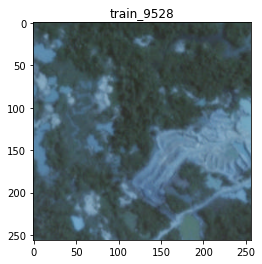

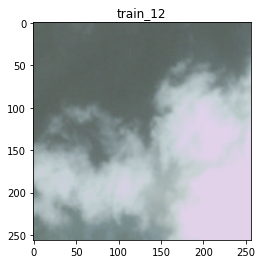

In [11]:
print_image('train_9528')
print_image('train_12')

# Посмотрим на размер картинок

In [12]:
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [13]:
def get_image_size(row):
    image_name = row['image_name']
    filepath = os.path.join('../../dataset_planet/train_images', f'{image_name}.jpg')
    image = cv2.imread(filepath)
    
    h, w, _ = image.shape
    row['h'] = h
    row['w'] = w
    return row

In [14]:
df = df.parallel_apply(get_image_size, axis=1)

In [15]:
df['h'].describe()
df['w'].describe()

count    40479.0
mean       256.0
std          0.0
min        256.0
25%        256.0
50%        256.0
75%        256.0
max        256.0
Name: h, dtype: float64

count    40479.0
mean       256.0
std          0.0
min        256.0
25%        256.0
50%        256.0
75%        256.0
max        256.0
Name: w, dtype: float64

# Посмотрим количество лейблов на одной картинке

In [16]:
df.iloc[:, 2:-2].sum(axis=1).describe()

count    40479.000000
mean         2.870748
std          1.218504
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          9.000000
dtype: float64

In [17]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

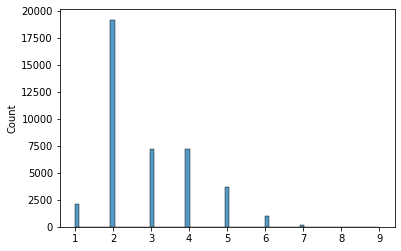

In [18]:
sns.histplot(data=df.iloc[:, 2:-2].sum(axis=1))